## Equations for Moment Closure of Network-based micro-model for divestment of bounded rational households.

Imports and setup

In [2]:
import sympy as s
import pickle as pkl
from sympy.abc import epsilon, phi, tau
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
s.init_printing()

Define variables and parameters for the adaptive voter model

In [6]:
# number of nodes
N = s.Symbol('N', integer=True)
# number of dirty nodes
Nd = s.Symbol('N_d', integer=True)
# number of clean nodes
Nc = s.Symbol('N_c', integer=True)
# number of edges
M = s.Symbol('M', integer=True)
# number of clean edges
cc = s.Symbol('[cc]', integer=True)
# number of dirty edges
dd = s.Symbol('[dd]', integer=True)
# number of mixed edges
cd = s.Symbol('[cd]', integer=True)
# average number of neighbors of clean nodes
kc = s.Symbol('k_c', integer=True)
# average number of neighbors of dirty nodes
kd = s.Symbol('k_d', integer=True)
# Nc - Nd
X = s.Symbol('X', real=True)
# cc - dd
Y = s.Symbol('Y', real=True)
# cd
Z = s.Symbol('Z', real=True, positive=True)
# wealth of dirty node
Wd = s.Symbol('W_d')
# wealth of clean node
Wc = s.Symbol('W_c')


Define variables and parameters for the economic subsystem:

In [7]:
# Total labor and labor shares in sectors
L, Lc, Ld = s.symbols('L L_c L_d', positive=True, real=True)
# Total capital in sectors
Kc, Kd = s.symbols('K_c K_d', positive=True, real=True)
# Equilibrium wage and capital return rates in sectors
w, rc, rd = s.symbols('w r_c r_d', positive=True, real=True)
# Resource usage rage, resource stock, knowledge Stock
R, G, C = s.symbols('R, G, C', positive=True, real=True)
# average capital endowments of clean and dirty households
# lower (first) index: capital type, upper (second) index: household type
Kcc, Kcd, Kdc, Kdd = s.symbols('K_c^c K_c^d K_d^c K_d^d', positive=True, real=True)
# savings rate, capital depreciaten rate, and elasticities of labor, capital and knowledge
rs, delta, pi, kappac, kappad, xi = s.symbols('s delta pi kappa_c, kappa_d xi', positive=True, rational=True, real=True)
# solow residuals of clean and dirty sector, prefactor for resource cost, energy efficiency, initial resource stock
bc, bd, bR, e, G0 = s.symbols('b_c b_d b_R e G_0', positive=True, real=True)
# substitutions for resolution on constraints from market clearing.
Xc, Xd, XR = s.symbols('X_c X_d X_R', positive=True, real=True)

Defination of relations between variables and calculation of substitution of *primitive variables* by *state variables* of the system

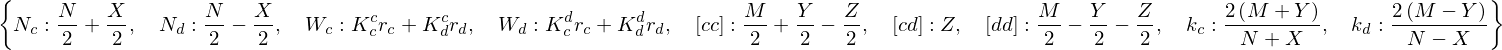

In [8]:
eqs = [
    # total number of households is fixed,
    Nd+Nc-N,
    # total number of edges is fixed,
    cc+dd+cd-M,
    # definition of state space variables
    X-Nc+Nd,
    Y-cc+dd,
    Z-cd,
    # mean degrees of clean and dirty nodes
    kc-(2*cc+cd)/Nc,
    kd-(2*dd+cd)/Nd
]
vars1 = (Nc, Nd, cc, dd, cd, kc, kd)
vars2 = (N, K, X, Y, Z)
subs1 = s.solve(eqs, vars1, dict=True)[0]

# define expected wealth as expected income
subs1[Wd] = rc * Kcd + rd * Kdd
subs1[Wc] = rc * Kcc + rd * Kdc
subs1

Jumps in state space i.e. Effect of events on state vector S = (X, Y, Z) - denoted r = X-X' in van Kampen

In [9]:
# regular adaptive voter events
s1 = s.Matrix([ 0, 1, -1]) # clean investor rewires
s2 = s.Matrix([ 0,-1, -1]) # dirty investor rewires
s3 = s.Matrix([-2,-kc,-1 + (1-1./kc)*((2*cc-cd)/Nc)]) # clean investor imitates c -> d
s4 = s.Matrix([ 2, kd,-1 + (1-1./kd)*((2*dd-cd)/Nd)]) # dirty investor imitates d -> c

# noise events

s5 = s.Matrix([-2,-(2*cc+cd)/Nc,(2*cc-cd)/Nc]) # c -> d
s6 = s.Matrix([ 2, (2*dd+cd)/Nd,(2*dd-cd)/Nd]) # d -> c
s7 = s.Matrix([ 0,-1, 1]) # c-c -> c-d
s8 = s.Matrix([ 0, 1,-1]) # c-d -> c-c
s9 = s.Matrix([ 0, 1, 1]) # d-d -> d-c
s10= s.Matrix([ 0,-1,-1]) # d-c -> d-d

Probabilities per unit time for events to occur (denoted by W in van Kampen)

In [10]:
p1 = 1./tau * (1-epsilon)*(Nc/N)*cd/(Nc * kc)*phi # clean investor rewires
p2 = 1./tau * (1-epsilon)*(Nd/N)*cd/(Nd * kd)*phi # dirty investor rewires
p3 = 1./tau * (1-epsilon)*(Nc/N)*cd/(Nc * kc)*(1-phi)*(1./2)*((Wd-Wc)/(Wd+Wc)+1) # clean investor imitates c -> d
p4 = 1./tau * (1-epsilon)*(Nd/N)*cd/(Nd * kd)*(1-phi)*(1./2)*((Wc-Wd)/(Wd+Wc)+1) # dirty investor imitates d -> c
p5 = 1./tau * epsilon * (1./2) * Nc/N # c -> d
p6 = 1./tau * epsilon * (1./2) * Nd/N # d -> c
p7 = 1./tau * epsilon * Nc/N * (2*cc)/(2*cc+cd) * Nd/N # c-c -> c-d
p8 = 1./tau * epsilon * Nc/N * (cd)/(2*cc+cd) * Nc/N   # c-d -> c-c
p9 = 1./tau * epsilon * Nd/N * (2*dd)/(2*dd+cd) * Nc/N # d-d -> d-c
p10= 1./tau * epsilon * Nd/N * (cd)/(2*dd+cd) * Nd/N   # d-c -> d-d

Create S and r matrices to write down rhs markov jump process for pair based proxy:

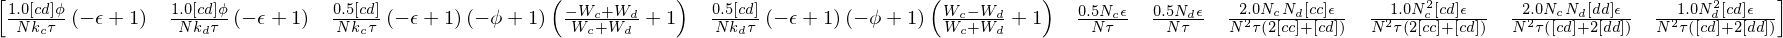

In [11]:
r = s.Matrix(s1)
for i, si in enumerate([s2, s3, s4, s5, s6, s7, s8, s9, s10]):
    r = r.col_insert(i+1, si)

W = s.Matrix([p1])
for j, pj in enumerate([s.Matrix([p]) for p in[p2, p3, p4, p5, p6, p7, p8, p9, p10]]):
    W = W.col_insert(j+1, pj)
W

rhs of the pair based proxy is given by the first jump moment. This is formally given by 

$\int r W(S,r) dr$

which in our case is equal to 

$\sum_i r_i W_{i, j}(S)$

To calculate this, we first write the jumps and transition matrix in terms of X, Y, Z and then substitute with rescalled variables and eliminate N.

In [12]:
r = r.subs(subs1)
W = W.subs(subs1)

In [14]:
x, y, z, m = s.symbols('x y z m')
c, g, l, g0 = s.symbols('c, g, l, g_0')
subs4 = {Kc: (Kcc + Kcd),
         Kd: (Kdc + Kdd),
         C: N * c,
         L: N * l,
         G: N * g,
         G0: N * g0,
         X: N*x,
         Y: N*k*y,
         Z: N*k*z,
         M: N*m}

In [15]:
r = r.subs(subs4)
W = W.subs(subs4)
for i in range(len(W)):
    W[i] = W[i].collect(N)
for i in range(len(r)):
    r[i] = r[i].collect(N)
    # flamming hack to circumvent sympies inability to collect with core.add.Add.
    # eyeballing the expressions it is obvious that this is justified.
    if isinstance(r[i], s.add.Add):
        print('printing expressions that sympy cant handle to check their treatment is appropriate')
        s.pretty_print(r[i])
        r[i] = r[i].subs({N: 1})

printing expressions that sympy cant handle to check their treatment is appropriate
     ⎛  0.5⋅(N⋅x + N)    ⎞                        
     ⎜- ───────────── + 1⎟⋅(N⋅k⋅y - 2⋅N⋅k⋅z + N⋅m)
     ⎝   N⋅k⋅y + N⋅m     ⎠                        
-1 + ─────────────────────────────────────────────
                        N⋅x   N                   
                        ─── + ─                   
                         2    2                   
printing expressions that sympy cant handle to check their treatment is appropriate
     ⎛  0.5⋅(-N⋅x + N)    ⎞                         
     ⎜- ────────────── + 1⎟⋅(-N⋅k⋅y - 2⋅N⋅k⋅z + N⋅m)
     ⎝   -N⋅k⋅y + N⋅m     ⎠                         
-1 + ───────────────────────────────────────────────
                          N⋅x   N                   
                        - ─── + ─                   
                           2    2                   


After eliminating N, we can write down the first jump moment:

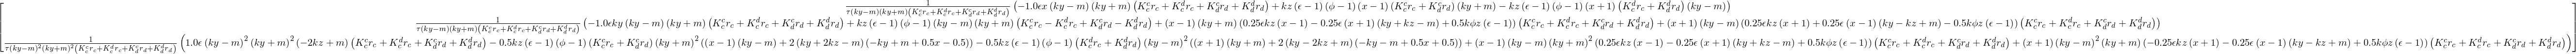

In [16]:
rhsPBP = s.Matrix(r*s.Transpose(W))
rhsPBP = s.Matrix(s.simplify(rhsPBP))
rhsPBP

**Next, we treat the equations describing economic production and capital accumulation**

Substitutute solutions to algebraic constraints of economic system (market clearing for labor and expressions for capital rent and resource flow)

In [17]:
subs2 = {w: pi * L**(pi-1.) * (Xc + Xd*XR)**(1.-pi),
        rc: kappac/Kc*Xc*L**pi*(Xc + Xd*XR)**(-pi),
        rd: kappad/Kd*Xd*XR*L**pi*(Xc + Xd*XR)**(-pi),
        R:  bd/e*Kd**kappad*L**pi*(Xd*XR/(Xc + Xd*XR))**pi,
        Lc: L*Xc/(Xc + Xd*XR),
        Ld: L*Xd*XR/(Xc + Xd*XR),
        Wd: rc * Kcd + rd * Kdd,
        Wc: rc * Kcc + rd * Kdc}

In [18]:
subs3 = {Xc: (bc*Kc**kappac * C**xi)**(1./(1.-pi)),
         Xd: (bd*Kd**kappad)**(1./(1.-pi)),
         XR: (1.-bR/e*(G0/G)**2)**(1./(1.-pi))}

Substitutions to ensure constant returns to scale:

In [59]:
subs5 = {kappac: 1. - pi - xi,
         kappad: 1. - pi}

Write down dynamic equations for the economic subsystem in terms of means of clean and dirty capital stocks for clean and dirty households

In [60]:
#change R for correct use of Kcc and Kcd
rhsECO = s.Matrix([(rs*rc-delta)*Kcc + rs*rd*Kdc + rs*w*L/N,
                  -delta*Kcd,
                  -delta*Kdc,
                  rs*rc*Kcd + (rs*rd-delta)*Kdd + rs*w*L/N,
                  bc*Lc**pi*(Nc*Kcc + Nd*Kcd)**kappac * C**xi - delta*C,
                  -R])


Write down changes in means of capital stocks through agents' switching of opinions and add them to the capital accuKlation terms

In [61]:
#TODO: change switching terms
dtNcd = 1./tau*Nc*(Nc/N*cd/(2*cc+cd)*(1-phi)*(1-epsilon)*1./2*(s.tanh(Wd-Wc)+1) + epsilon*1./2*Nc/N)
dtNdc = 1./tau*Nd*(Nd/N*cd/(2*dd+cd)*(1-phi)*(1-epsilon)*1./2*(s.tanh(Wc-Wd)+1) + epsilon*1./2*Nd/N)

rhsECO_switch = s.Matrix([(Kdc-Kcc)*dtNdc/Nc,
                         (Kdd-Kcd)*dtNdc/Nc,
                         (Kcc-Kdc)*dtNcd/Nd,
                         (Kcd-Kdd)*dtNcd/Nd,
                         0,
                         0])
rhsECO_switch = s.simplify(rhsECO_switch.subs(subs1))

In [62]:
rhsECO = rhsECO + rhsECO_switch

Next, we have to write the economic system in terms of X, Y, Z and then in terms of rescalled variables and ckeck the dependency on the system size N: 
- 1) substitute primitive variables for dependent variables (subs1)
- 2) substitute dependent variables for system variables (subs4)

In [63]:
rhsECO = rhsECO.subs(subs1).subs(subs2).subs(subs3).subs(subs4).subs(subs5)

In the PBP rhs substitute economic variables for their propper expressions ($r_c$, $r_d$ ect.) and then again substitute lingering 'primitive' variables with rescalled ones

In [64]:
rhsPBP = rhsPBP.subs(subs2).subs(subs3).subs(subs5)
rhsPBP = rhsPBP.subs(subs1).subs(subs4).subs({N: 1})

Check expressions to assure eliminating N the evil way does not break stuff

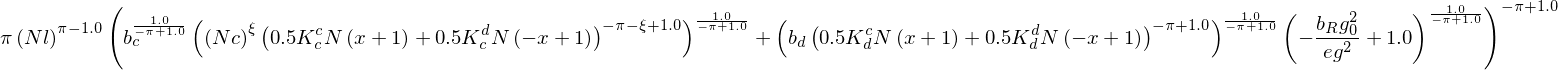

In [65]:
subs2[w].subs(subs3).subs(subs5).subs(subs1).subs(subs4).collect(N)

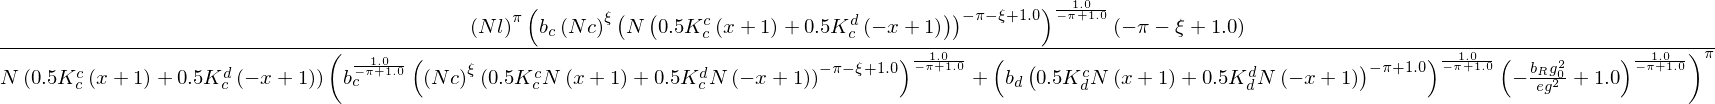

In [66]:
subs2[rc].subs(subs3).subs(subs5).subs(subs1).subs(subs4).collect(N)

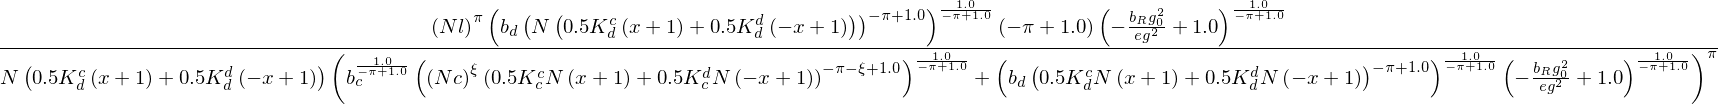

In [67]:
subs2[rd].subs(subs3).subs(subs5).subs(subs1).subs(subs4).collect(N)

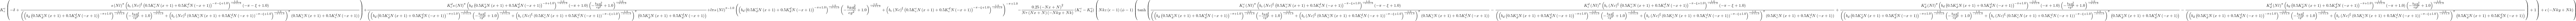

In [68]:
rhsECO[0]

Combine dynamic equations of economic and social subsystem:

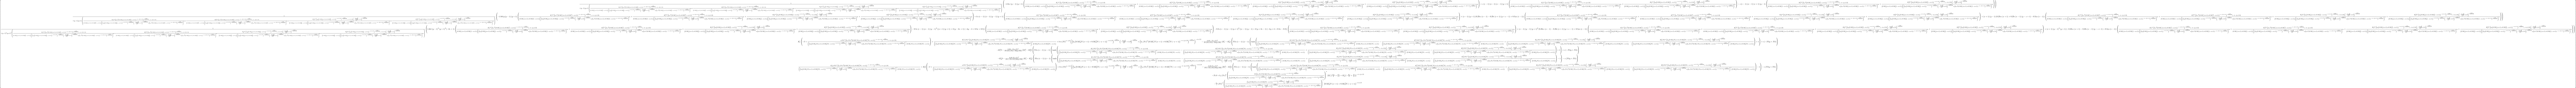

In [69]:
rhs = s.Matrix([rhsPBP,rhsECO]).subs(subs1)
rhs

In [70]:
with open('res_aggregate_raw.pkl', 'wb') as outf:
    pkl.dump(rhs, outf)

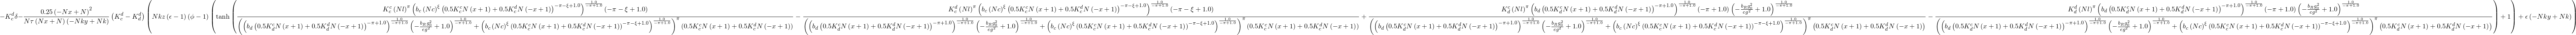

In [71]:
rhs[4]